## Import necessary libraries

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Convert mask to bounding boxes

In [2]:
def mask_to_bboxes(mask):
    bboxes = []
    for class_id in np.unique(mask):
        if class_id == 0:  # Skip background
            continue
        # Find contours for the current class
        contours, _ = cv2.findContours((mask == class_id).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append((class_id, x, y, x + w, y + h))
    return bboxes

## Process dataset and save bounding boxes to YOLO format.

In [3]:
def process_dataset(image_dir, mask_dir, output_file):
    with open(output_file, 'w') as f:
        for mask_filename in os.listdir(mask_dir):
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error loading mask: {mask_path}")
                continue

            bboxes = mask_to_bboxes(mask)
            image_filename = mask_filename.replace('_lab.png', '.jpg')
            image_path = os.path.join(image_dir, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {image_path}")
                continue

            h, w, _ = image.shape
            for bbox in bboxes:
                class_id, x_min, y_min, x_max, y_max = bbox
                # Convert to YOLO format (normalized coordinates)
                x_center = (x_min + x_max) / 2.0 / w
                y_center = (y_min + y_max) / 2.0 / h
                width = (x_max - x_min) / w
                height = (y_max - y_min) / h
                f.write(f"{image_path} {class_id} {x_center} {y_center} {width} {height}\n")

In [6]:
# Set your paths
image_dir = 'data/test-org-img'
mask_dir = 'data/test-label-img'
output_file = 'yolo_annotations.txt'

# Process the dataset
process_dataset(image_dir, mask_dir, output_file)

## Define class labels and colors for each class

In [4]:
class_labels = {
    1: 'debris',
    2: 'water',
    3: 'building-no-damage',
    4: 'building-medium-damage',
    5: 'building-major-damage',
    6: 'building-total-destruction',
    7: 'vehicle',
    8: 'road',
    9: 'tree',
    10: 'pool',
    11: 'sand'
}

colors = {
    1: (0, 255, 0),     # Green for debris
    2: (0, 0, 255),     # Red for water
    3: (255, 0, 0),     # Blue for building-no-damage
    4: (255, 255, 0),   # Cyan for building-medium-damage
    5: (0, 255, 255),   # Yellow for building-major-damage
    6: (255, 0, 255),   # Magenta for building-total-destruction
    7: (0, 165, 255),   # Orange for vehicle
    8: (255, 165, 0),   # Orange for road
    9: (255, 20, 147),  # Deep pink for tree
    10: (138, 43, 226), # Blue violet for pool
    11: (75, 0, 130)    # Indigo for sand
}

## Visualise bboxes according to annotations

In [16]:
def visualize_bboxes(image_path, annotations_file):
    # Read the image
    image = cv2.imread(image_path)
    # resize image to 640x640
    image = cv2.resize(image, (640, 640))
    print(image.shape)
    if image is None:
        print(f"Error loading image: {image_path}")
        return
    
    # Read the annotations
    with open(annotations_file, 'r') as f:
        annotations = f.readlines()
    
    # Parse the annotations
    h, w, _ = image.shape
    for annotation in annotations:
        parts = annotation.strip().split()
        img_path, class_id, x_center, y_center, width, height = parts
        if img_path != image_path:
            continue
        
        # Convert YOLO format to bounding box coordinates
        x_center = float(x_center) * w
        y_center = float(y_center) * h
        width = float(width) * w
        height = float(height) * h
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        
        # Get class ID as integer
        class_id = int(class_id)
        
        # Draw the bounding box
        color = colors.get(class_id, (255, 255, 255))  # Default to white if class_id not found
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        label = class_labels.get(class_id, 'unknown')
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

(640, 640, 3)


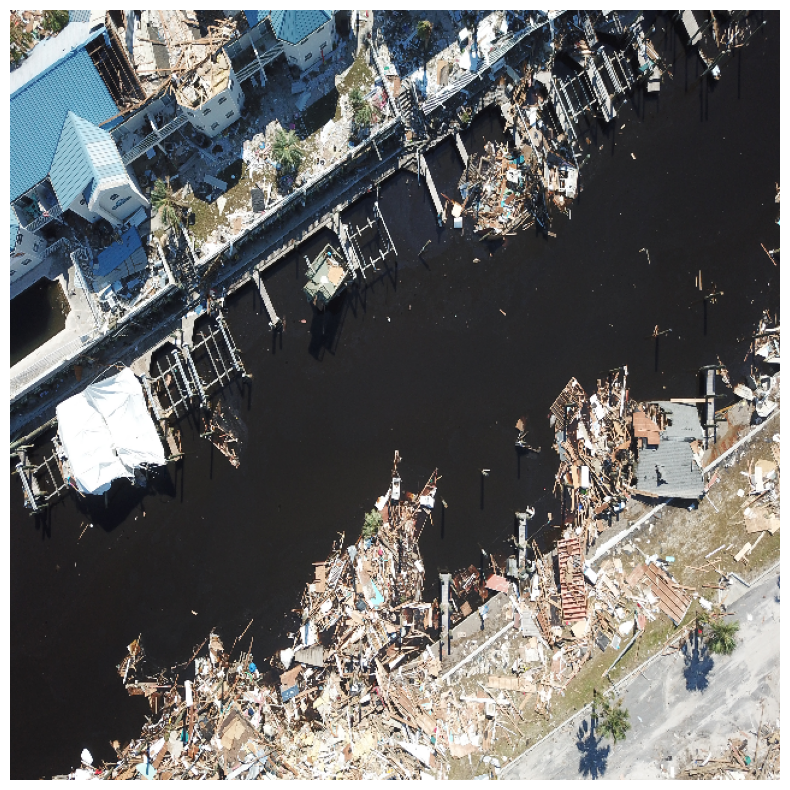

In [17]:
# Set the paths
image_path = '../data/images/train/10778.jpg'
annotations_file = '../preprocess/bboxes/yolo_annotations.txt'

# Visualize the bounding boxes
visualize_bboxes(image_path, annotations_file)